In [1]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model
import torch

import loader
from models import MLPClassifier, BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
split_ratio_calib = 0.3
n_bins_calib = 70

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/acsincome"

In [2]:
## Load ACSIncome dataset from `folktables`

(inputs_df, labels, label_names, groups, group_names) = loader.cache_dataset(
    f"{data_dir}/acsincome2.pkl", lambda: loader.load_acsincome(
        data_dir,
        n_classes=2,
        sensitive_attr='SEX',
    ))
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32, copy=True)
inputs_df.drop(columns=list(inputs_df.filter(regex=f'^SEX_')), inplace=True)
inputs_u = inputs_df.values.astype(np.float32)

Group,Male,Female
Target,,
<=50K,483923,566510
>50K,382812,231255


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 0.16995712996392176


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

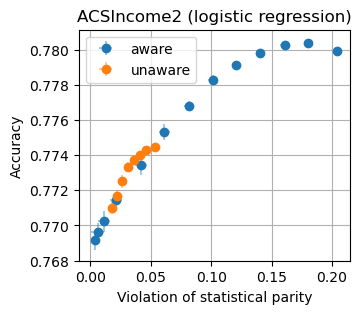

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.779939  0.000162  0.204323  0.000608
0.180  0.780367  0.000173  0.180478  0.003211
0.160  0.780256  0.000175  0.160661  0.003625
0.140  0.779815  0.000239  0.140567  0.003484
0.120  0.779108  0.000254  0.120769  0.003176
0.100  0.778284  0.000256  0.101278  0.003611
0.080  0.776791  0.000302  0.081540  0.004008
0.060  0.775316  0.000429  0.061336  0.004803
0.040  0.773436  0.000541  0.041731  0.004833
0.020  0.771429  0.000493  0.021501  0.004882
0.010  0.770230  0.000616  0.011423  0.005080
0.005  0.769615  0.000540  0.006267  0.005213
0.001  0.769173  0.000584  0.004287  0.003160

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.774478  0.000212  0.053829  0.000802
0.030  0.774273  0.000260  0.045968  0.001146
0.025  0.773991  0.000266  0.041167  0.001069
0.020  0.773739  0.000220  0.036245  0.001040
0.015  0.773309  0.000289  0.031512  0.001264
0.010  0.772507  0.000362  0.026519  0.001199
0.005  0.771679  0.000339  0.021851  0.001278
0.001  0.771008  0.000362  0.018017  0.001129

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.005, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

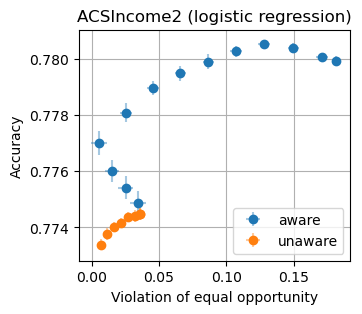

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.779939  0.000162   0.181835  0.001177
0.200  0.780079  0.000145   0.171142  0.004321
0.180  0.780393  0.000176   0.149894  0.003936
0.160  0.780520  0.000141   0.128126  0.004300
0.140  0.780272  0.000201   0.107095  0.004571
0.120  0.779899  0.000265   0.086722  0.004350
0.100  0.779479  0.000254   0.065872  0.004228
0.080  0.778963  0.000239   0.045705  0.004660
0.060  0.778089  0.000353   0.025585  0.004659
0.040  0.777009  0.000424   0.005465  0.005582
0.020  0.776008  0.000382   0.015175  0.005307
0.010  0.775418  0.000421   0.025269  0.005746
0.001  0.774853  0.000453   0.034280  0.005908

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.774478  0.000212   0.035940  0.001269
0.030  0.774478  0.000208   0.035910  0.001329
0.025  0.774403  0.000205   0.032104  0.001954
0.020  0.774377  0.000177   0.026925  0.001851
0.015  0.774154  0.000182   0.021599  0.001693
0.010  0.774006  0.000184   0.016909  0.002206
0.005  0.773782  0.000210   0.011493  0.002393
0.001  0.773384  0.000193   0.006818  0.002116

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

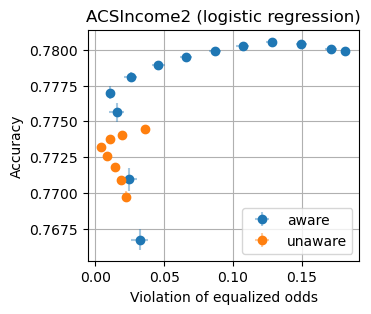

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.779939  0.000162  0.181835  0.001177
0.200  0.780079  0.000145  0.171142  0.004321
0.180  0.780393  0.000176  0.149894  0.003936
0.160  0.780520  0.000141  0.128126  0.004300
0.140  0.780272  0.000201  0.107095  0.004571
0.120  0.779899  0.000265  0.086722  0.004350
0.100  0.779479  0.000254  0.065872  0.004228
0.080  0.778963  0.000239  0.045705  0.004660
0.060  0.778089  0.000353  0.025585  0.004659
0.040  0.777009  0.000424  0.010483  0.002674
0.020  0.775632  0.000664  0.015419  0.005413
0.010  0.770945  0.000811  0.024036  0.006160
0.001  0.766741  0.000731  0.032187  0.006274

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.774478  0.000212  0.035940  0.001269
0.030  0.774068  0.000187  0.019123  0.001638
0.025  0.773746  0.000162  0.010531  0.001360
0.020  0.773209  0.000224  0.004324  0.000782
0.015  0.772573  0.000269  0.008726  0.000826
0.010  0.771788  0.000278  0.014222  0.001396
0.005  0.770879  0.000312  0.018440  0.001090
0.001  0.769742  0.000396  0.022017  0.001236

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

[LightGBM] [Info] Number of positive: 386611, number of negative: 662024
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 1048635, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368680 -> initscore=-0.537883
[LightGBM] [Info] Start training from score -0.537883


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 1048635, number of used features: 51
[LightGBM] [Info] Start training from score -1.235280
[LightGBM] [Info] Start training from score -1.470834
[LightGBM] [Info] Start training from score -1.077145
[LightGBM] [Info] Start training from score -1.973667


Calibration error of attribute-blind predictor: 0.14711484417748807


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

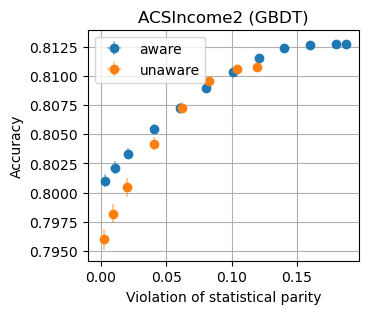

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.812750  0.000308  0.187952  0.000441
0.180  0.812749  0.000300  0.180165  0.001926
0.160  0.812691  0.000303  0.160287  0.002572
0.140  0.812407  0.000303  0.140489  0.002324
0.120  0.811493  0.000268  0.120848  0.002538
0.100  0.810371  0.000284  0.100902  0.002316
0.080  0.808966  0.000339  0.080573  0.002681
0.060  0.807250  0.000396  0.060812  0.002934
0.040  0.805464  0.000425  0.040934  0.003050
0.020  0.803347  0.000441  0.021079  0.003602
0.010  0.802146  0.000542  0.011033  0.003713
0.001  0.801018  0.000546  0.003461  0.001873

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.810754  0.000253  0.119561  0.000548
0.100  0.810607  0.000268  0.104370  0.002249
0.080  0.809555  0.000331  0.082660  0.002470
0.060  0.807275  0.000467  0.061935  0.002494
0.040  0.804187  0.000565  0.040863  0.002710
0.020  0.800447  0.000779  0.020140  0.003044
0.010  0.798210  0.000836  0.009331  0.003397
0.001  0.795997  0.000925  0.002099  0.002522

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

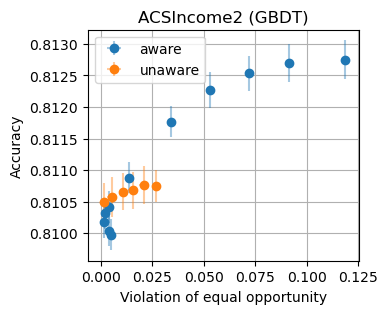

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.812750  0.000308   0.118865  0.000739
0.100  0.812699  0.000305   0.091500  0.001192
0.080  0.812535  0.000278   0.071891  0.001311
0.060  0.812272  0.000287   0.053015  0.001434
0.040  0.811770  0.000246   0.033987  0.001468
0.020  0.810880  0.000244   0.013766  0.001431
0.010  0.810416  0.000254   0.004006  0.001414
0.008  0.810315  0.000243   0.001960  0.001325
0.005  0.810179  0.000248   0.001440  0.000950
0.002  0.810034  0.000242   0.003977  0.001394
0.001  0.809979  0.000246   0.004878  0.001353

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.810754  0.000253   0.026850  0.000505
0.020  0.810768  0.000300   0.020757  0.002344
0.015  0.810679  0.000292   0.015621  0.002334
0.010  0.810657  0.000293   0.010702  0.001995
0.005  0.810575  0.000312   0.005216  0.002117
0.001  0.810500  0.000302   0.001531  0.001758

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

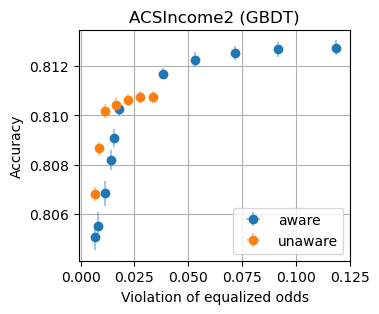

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.812750  0.000308  0.118865  0.000739
0.100  0.812699  0.000305  0.091500  0.001192
0.080  0.812535  0.000278  0.071891  0.001311
0.060  0.812272  0.000287  0.053015  0.001434
0.040  0.811700  0.000230  0.038170  0.001611
0.020  0.810247  0.000283  0.017715  0.001754
0.010  0.809085  0.000365  0.015484  0.001386
0.008  0.808200  0.000399  0.013975  0.001577
0.005  0.806842  0.000512  0.011228  0.001417
0.002  0.805510  0.000583  0.008046  0.001345
0.001  0.805062  0.000541  0.006518  0.001275

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.810754  0.000253  0.033849  0.000847
0.025  0.810752  0.000255  0.027449  0.001533
0.020  0.810621  0.000255  0.021971  0.001330
0.015  0.810433  0.000259  0.016539  0.001148
0.010  0.810177  0.000298  0.011540  0.000588
0.005  0.808658  0.000254  0.008395  0.001001
0.001  0.806808  0.000289  0.006832  0.001794

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## ReLU network

In [14]:
# Train attribute-aware p(Y | X) predictor
predictor_y = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                            activation=torch.nn.ReLU(),
                            n_classes=n_classes,
                            n_epochs=20,
                            batch_size=128,
                            lr=1e-3,
                            gamma=0.8,
                            device=device,
                            random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 0.1404798268689295


In [15]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

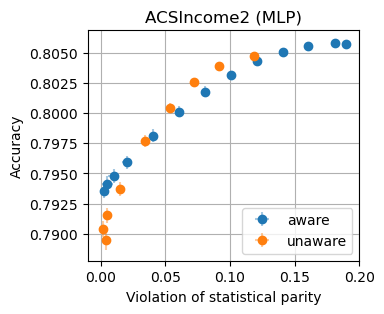

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.805695  0.000253  0.190157  0.000356
0.180  0.805778  0.000240  0.180954  0.001891
0.160  0.805504  0.000221  0.160699  0.001913
0.140  0.805024  0.000254  0.141051  0.002474
0.120  0.804316  0.000288  0.120918  0.002900
0.100  0.803152  0.000305  0.100941  0.003149
0.080  0.801772  0.000433  0.081057  0.003366
0.060  0.800118  0.000437  0.061001  0.003371
0.040  0.798132  0.000521  0.040632  0.003540
0.020  0.795911  0.000560  0.020275  0.003969
0.010  0.794782  0.000590  0.010167  0.004267
0.005  0.794148  0.000610  0.005309  0.003975
0.001  0.793585  0.000642  0.002930  0.002672

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.804680  0.000234  0.118973  0.000572
0.100  0.803871  0.000269  0.091630  0.002838
0.080  0.802563  0.000285  0.072628  0.002717
0.060  0.800428  0.000366  0.053755  0.002690
0.040  0.797678  0.000515  0.034538  0.002803
0.020  0.793744  0.000591  0.014744  0.002928
0.010  0.791541  0.000615  0.004905  0.002925
0.005  0.790422  0.000668  0.001912  0.002048
0.001  0.789464  0.000807  0.004110  0.002866

In [16]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.005, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

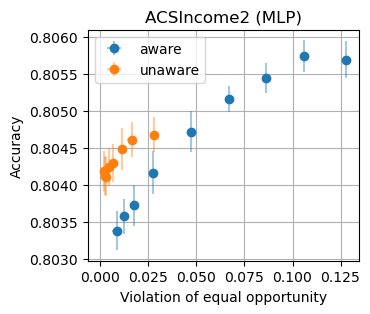

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.805695  0.000253   0.127691  0.000642
0.100  0.805745  0.000213   0.105939  0.001656
0.080  0.805448  0.000206   0.086324  0.001838
0.060  0.805162  0.000172   0.066851  0.002112
0.040  0.804722  0.000272   0.047230  0.002018
0.020  0.804166  0.000295   0.027392  0.002334
0.010  0.803723  0.000274   0.017610  0.002249
0.005  0.803576  0.000237   0.012463  0.002256
0.001  0.803378  0.000263   0.008446  0.002199

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.804680  0.000234   0.028110  0.000542
0.020  0.804612  0.000237   0.016358  0.002648
0.015  0.804489  0.000286   0.011280  0.002056
0.010  0.804298  0.000258   0.006441  0.001876
0.008  0.804246  0.000258   0.004273  0.002167
0.005  0.804189  0.000269   0.001821  0.001821
0.002  0.804123  0.000264   0.002484  0.001118
0.001  0.804112  0.000261   0.003047  0.001436

In [17]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

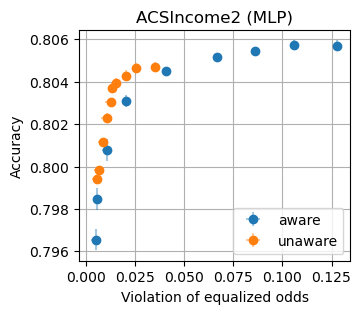

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.805695  0.000253  0.127691  0.000642
0.100  0.805745  0.000213  0.105939  0.001656
0.080  0.805448  0.000206  0.086324  0.001838
0.060  0.805162  0.000172  0.066851  0.002112
0.040  0.804512  0.000200  0.040653  0.002054
0.020  0.803094  0.000279  0.020681  0.001983
0.010  0.800785  0.000529  0.010694  0.002570
0.005  0.798467  0.000497  0.005838  0.002258
0.001  0.796544  0.000491  0.005290  0.002354

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.804680  0.000234  0.035338  0.000705
0.030  0.804637  0.000240  0.025556  0.001670
0.025  0.804282  0.000265  0.020715  0.001956
0.020  0.803939  0.000231  0.015498  0.001969
0.015  0.803708  0.000221  0.013370  0.001054
0.010  0.803021  0.000205  0.012763  0.002869
0.008  0.802299  0.000207  0.010667  0.002763
0.005  0.801140  0.000172  0.008870  0.002675
0.002  0.799838  0.000199  0.006664  0.002603
0.001  0.799390  0.000197  0.005738  0.002604

In [18]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Calibration (attribute-blind setting)

In [19]:
# Split pre-training data into calibration and training sets
inputs_u_train, inputs_u_calib, labels_ay_train, labels_ay_calib = sklearn.model_selection.train_test_split(
    inputs_u_pretrain,
    labels_ay_pretrain,
    test_size=split_ratio_calib,
    random_state=seed_pretrain,
)

### Logistic regression

In [20]:
# Train p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [21]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/60 [00:00<?, ?it/s]

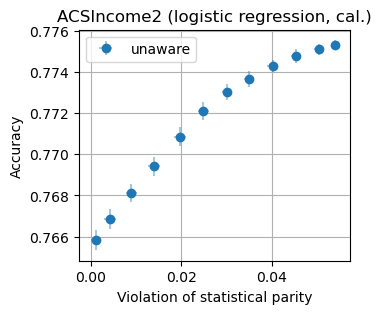

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.775284  0.000246  0.053941  0.000790     0.053941  0.000790
0.050  0.775099  0.000272  0.050465  0.001058     0.050465  0.001058
0.045  0.774766  0.000328  0.045444  0.001131     0.045444  0.001131
0.040  0.774281  0.000302  0.040270  0.001234     0.040270  0.001234
0.035  0.773631  0.000388  0.035031  0.001172     0.035031  0.001172
0.030  0.773009  0.000383  0.030058  0.001123     0.030058  0.001123
0.025  0.772088  0.000445  0.024930  0.001306     0.024930  0.001306
0.020  0.770854  0.000461  0.019669  0.001314     0.019669  0.001314
0.015  0.769411  0.000473  0.013989  0.001300     0.013989  0.001300
0.010  0.768110  0.000447  0.008969  0.001271     0.008969  0.001271
0.005  0.766869  0.000472  0.004269  0.001344     0.004269  0.001344
0.001  0.765827  0.000481  0.001164  0.001007     0.001164  0.001007

In [22]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005,
        0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

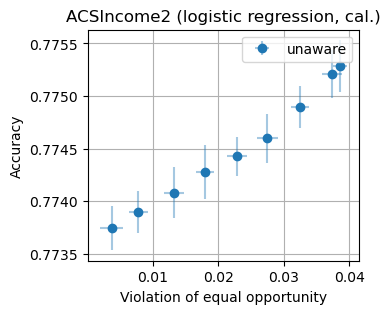

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.775284  0.000246   0.038582  0.001063       0.038582  0.001063
0.035  0.775210  0.000227   0.037415  0.001516       0.037415  0.001516
0.030  0.774891  0.000200   0.032494  0.001365       0.032494  0.001365
0.025  0.774597  0.000230   0.027505  0.001559       0.027505  0.001559
0.020  0.774427  0.000186   0.022845  0.001508       0.022845  0.001508
0.015  0.774276  0.000253   0.017990  0.001359       0.017990  0.001359
0.010  0.774081  0.000246   0.013166  0.001527       0.013166  0.001527
0.005  0.773896  0.000198   0.007787  0.001470       0.007787  0.001470
0.001  0.773744  0.000212   0.003724  0.001727       0.003724  0.001727

In [23]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

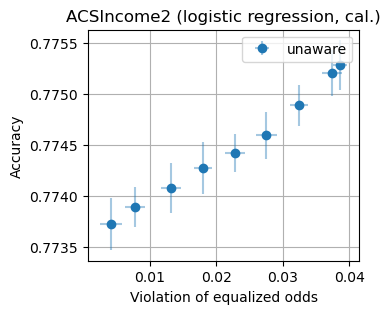

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.775284  0.000246  0.038582  0.001063     0.028900  0.000739
0.035  0.775210  0.000227  0.037415  0.001516     0.027972  0.001109
0.030  0.774891  0.000200  0.032494  0.001365     0.024083  0.001013
0.025  0.774597  0.000230  0.027505  0.001559     0.020144  0.001142
0.020  0.774427  0.000186  0.022845  0.001508     0.016496  0.001054
0.015  0.774276  0.000253  0.017990  0.001359     0.012886  0.000977
0.010  0.774081  0.000246  0.013166  0.001527     0.009352  0.001084
0.005  0.773896  0.000198  0.007787  0.001470     0.005564  0.001015
0.001  0.773729  0.000257  0.004171  0.001613     0.003088  0.001078

In [24]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

### Gradient boosting decision tree

In [25]:
# Train p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 734044, number of used features: 51
[LightGBM] [Info] Start training from score -1.236624
[LightGBM] [Info] Start training from score -1.470886
[LightGBM] [Info] Start training from score -1.075310
[LightGBM] [Info] Start training from score -1.975274


In [26]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/40 [00:00<?, ?it/s]

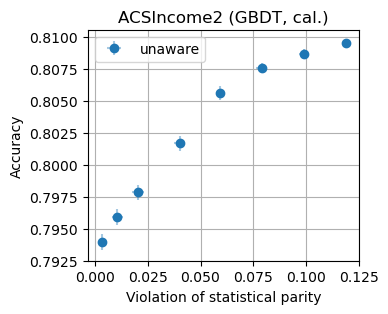

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.809474  0.000253  0.118797  0.000636     0.118797  0.000636
0.100  0.808652  0.000366  0.099151  0.002285     0.099151  0.002285
0.080  0.807523  0.000387  0.078997  0.002581     0.078997  0.002581
0.060  0.805577  0.000554  0.059463  0.002330     0.059463  0.002330
0.040  0.801668  0.000566  0.040074  0.002507     0.040074  0.002507
0.020  0.797846  0.000574  0.020333  0.002785     0.020333  0.002785
0.010  0.795894  0.000618  0.010566  0.002693     0.010566  0.002693
0.001  0.793957  0.000652  0.003067  0.000546     0.003067  0.000546

In [27]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

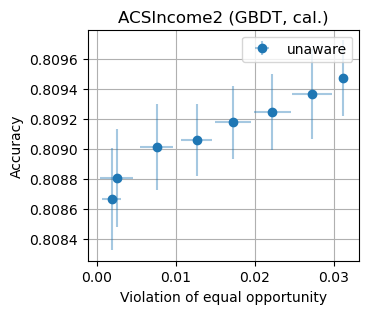

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.809474  0.000253   0.031196  0.000436       0.031196  0.000436
0.030  0.809365  0.000300   0.027179  0.002501       0.027179  0.002501
0.025  0.809248  0.000251   0.022179  0.002335       0.022179  0.002335
0.020  0.809180  0.000244   0.017237  0.002284       0.017237  0.002284
0.015  0.809063  0.000241   0.012614  0.001940       0.012614  0.001940
0.010  0.809013  0.000288   0.007558  0.002096       0.007558  0.002096
0.005  0.808809  0.000327   0.002541  0.002090       0.002541  0.002090
0.001  0.808667  0.000343   0.001897  0.001204       0.001897  0.001204

In [28]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

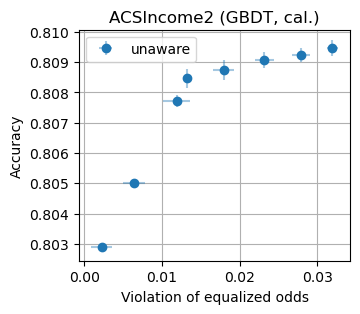

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.809474  0.000253  0.031940  0.000727     0.031572  0.000436
0.030  0.809230  0.000232  0.027860  0.001157     0.025258  0.001402
0.025  0.809067  0.000256  0.023193  0.001219     0.018501  0.001161
0.020  0.808737  0.000330  0.017963  0.001354     0.012772  0.000979
0.015  0.808463  0.000322  0.013247  0.000588     0.011538  0.000665
0.010  0.807730  0.000202  0.011888  0.001743     0.010222  0.000751
0.005  0.805016  0.000141  0.006413  0.001426     0.005284  0.000784
0.001  0.802879  0.000091  0.002235  0.001301     0.001778  0.000989

In [29]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

### ReLU network

In [30]:
# Train p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [31]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/45 [00:00<?, ?it/s]

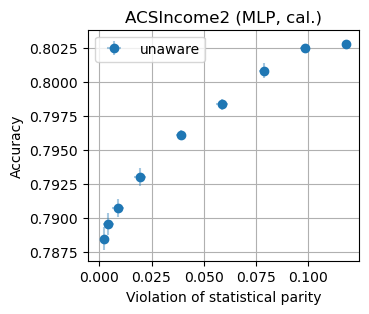

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.802756  0.000284  0.117832  0.000619     0.117832  0.000619
0.100  0.802450  0.000344  0.098471  0.002268     0.098471  0.002268
0.080  0.800797  0.000550  0.078635  0.002444     0.078635  0.002444
0.060  0.798320  0.000389  0.058724  0.002681     0.058724  0.002681
0.040  0.796062  0.000391  0.039150  0.002494     0.039150  0.002494
0.020  0.792980  0.000659  0.019373  0.002813     0.019373  0.002813
0.010  0.790687  0.000658  0.009117  0.002899     0.009117  0.002899
0.005  0.789509  0.000792  0.004410  0.002771     0.004410  0.002771
0.001  0.788443  0.000848  0.002460  0.001942     0.002460  0.001942

In [32]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

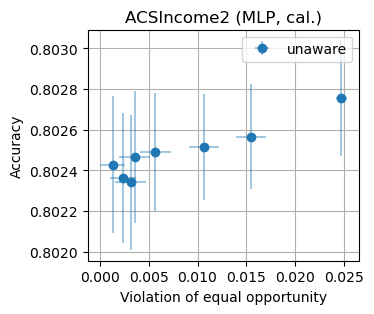

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.802756  0.000284   0.024722  0.000566       0.024722  0.000566
0.020  0.802567  0.000257   0.015493  0.001509       0.015493  0.001509
0.015  0.802514  0.000261   0.010708  0.001539       0.010708  0.001539
0.010  0.802490  0.000292   0.005692  0.001579       0.005692  0.001579
0.008  0.802466  0.000324   0.003579  0.001609       0.003579  0.001609
0.005  0.802428  0.000338   0.001344  0.001283       0.001344  0.001283
0.002  0.802363  0.000321   0.002353  0.001341       0.002353  0.001341
0.001  0.802341  0.000333   0.003162  0.001574       0.003162  0.001574

In [33]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/50 [00:00<?, ?it/s]

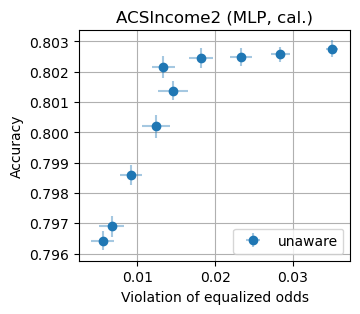

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.802756  0.000284  0.034984  0.000796     0.030294  0.000431
0.030  0.802571  0.000258  0.028375  0.001253     0.022710  0.000938
0.025  0.802502  0.000298  0.023317  0.001412     0.017428  0.001092
0.020  0.802462  0.000331  0.018176  0.001522     0.012887  0.001109
0.015  0.802160  0.000368  0.013356  0.001455     0.010847  0.000619
0.010  0.801376  0.000309  0.014593  0.001927     0.011990  0.001107
0.008  0.800202  0.000386  0.012392  0.001765     0.009944  0.001030
0.005  0.798590  0.000323  0.009195  0.001416     0.007007  0.000907
0.002  0.796898  0.000338  0.006702  0.001595     0.004854  0.001105
0.001  0.796425  0.000312  0.005565  0.001455     0.004085  0.001092

In [34]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)